In [2]:
import os
import qm
from entropylab import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%config Completer.use_jedi = False



<div align="center"> <font size="+5"><u>Entropy: A lab workflow manager<\u></font></div>


Entropy is a tool for managing your quantum workflow. It allows you to build complex experiments, coordinating lab instruments and arbitrary computational steps.

It is built to solve three major problems: data collection, device management and calibration automation. This notebook introduces the basic concepts needed to start working with this tool. 


# The Experiment and Graph

An experiment is a set of steps which may or may not be directly dependent on each other. You may want to run steps (or *not* run them) 
based on the result of a previous step. You may want to run steps using a result from a previous step. And you will almost always need to have 
access to the results each previous step had generated. 

This model is well described by a _Directed Acyclic Graph_ (DAG). _Directed_ means there is a direction to the flow of the graph, 
from root to leaves. _Acyclic_ means there shouldn't be closed loops in which you can get "stuck" when flowing through the graph.
DAG based authoring of experiments is perhaps the defining feature of Entropy. 

A simple DAG is shown below. Each experimental stage can be placed in a separate node and nodes pass data to descendant nodes. This is marked as "res"
on vertices in the image. Note how you can also set the node run order without passing data between nodes. For example, noded `b` and `d` have a vertex 
connecting them but no data is passed. 

![](DAG.svg)


The data passed into, and out of nodes is automatically saved to the result handeling backend (see below). But we can also take advantage of the 
strucutre to do some pretty nifty things. A graph run can have branching logic (conditional execution of branches), can be parameterized and there can 
be more than one way to traverse a graph from one end to another. This last point is particularly important when you have a graph with one **target** node, 
including the algorithm you really want to run and many **calibration** nodes with the all the experimental prerequisites. Solving the problem of complex 
calibration is actually the first task we had in mind for this project. 

## Building your first graph

The `PyNode` is the basic element in an Entropy grpah. It runs arbitrary python code defined in the `program` parameter. 
In the example below, the `program` is defined by the function `node_operation` which doesn't do anything but returns a dictionary with the key:value pair ```{`res`:1}```. 
Programs used in PyNodes must always return a dictionary. The node also has a name, set by `label` and defined the names of the variables it (optionally) passes on to other nodes. 

```python
def node_operation():
    return {'res':1}

node1 = PyNode(label="first_node", program=node_operation,output_vars={'res'})

```

You can now attache the node to a graph (containing just one node) 

```python
experiment = Graph(resources=None, graph={node1}, story="run_a") 
```

There are some explanations in order here. You can see that this graph has the `resources` parameter set to `None`, but we have not defined resources yet. 
We also didn't say anything about the `story` associated with a graph. But let's ignore that for now. 

We can now run the graph, saving the results to `handle`



In [4]:
def node_operation():
    return {'res':1}

node1 = PyNode(label="first_node", program=node_operation,output_vars={'res'})
experiment = Graph(resources=None, graph={node1}, story="run_a") 
handle = experiment.run()

2021-05-09 18:57:20,103 - entropy - WARNING - Results of current execution None will be permanently lost on session close
2021-05-09 18:57:20,107 - entropy - INFO - Running node <PyNode> first_node
2021-05-09 18:57:20,109 - entropy - INFO - Finished entropy experiment execution successfully


"What's with the `WARNING`?" you may ask. Because we didn't define any `resources`, and we don't have a backend for result saving defined, Entropy warns us we will not have any persistance (nothing will be saved for posterity). 
We will address this issue soon. Regardless, while in the python session, we can access the (wholly unspectacular) experiment results as follows:

In [5]:
handle.results.get_results_from_node("first_node")[0].results[0].data

1

You can see the returned result is what was returned by `node_operation`. There is clearly some strucutre here: results are returned in a list, 
that list is made of a certain type of object and so on. We will go into more detail later but will gloss over this for now. 

To view the graph, you need to have `graphviz` installed ([installation guide](https://graphviz.org/download/)). If it's properly installed on your environment, you can view the graph as follows:

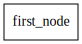

In [6]:
handle.dot_graph()

If not, you can use a textual representation of the graph. This is called `dot` notation and is a standard way to serialize a graph. To access the dot representation, run the following commnad

In [7]:
print(str(handle.dot_graph()))

digraph {
	first_node [shape=box]
}


This string can then be pasted in a service such as [GraphVizOnline](https://dreampuf.github.io/GraphvizOnline/) or [Edotor](https://edotor.net/) to get the graphical representation. 



## A graph with two nodes

As a graph with a single node is hardly a graph, here's an example containing two nodes which pass a result between them. 

For simpliciy, both nodes are running the same operation (same `node_operation` as before)

2021-05-09 18:57:47,153 - entropy - WARNING - Results of current execution None will be permanently lost on session close
2021-05-09 18:57:47,155 - entropy - INFO - Running node <PyNode> first_node
2021-05-09 18:57:47,156 - entropy - INFO - Running node <PyNode> first_node
2021-05-09 18:57:47,158 - entropy - INFO - Finished entropy experiment execution successfully


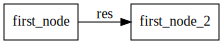

In [8]:
node1 = PyNode(label="first_node", program=node_operation,output_vars={'res'})
node2 = PyNode(label="first_node", program=node_operation,output_vars={'res'},input_vars={'ina':node1.outputs['res']})
experiment = Graph(resources=None, graph={node1,node2}, story="run_a") 
handle = experiment.run()
graph=handle.dot_graph()
graph.graph_attr['rankdir'] = 'LR'
graph

By inspecting the results object, we can see we have two `ResultRecord`s coming from each of the nodes, and an additional one which is automatically added. The additional record is the result of the final node and it is always included. 

In [9]:
handle.results.get_results()

[ResultRecord(experiment_id=1620575867155736600, id=0, label='res', story=None, stage=0, data=1),
 ResultRecord(experiment_id=1620575867155736600, id=1, label='res', story=None, stage=1, data=1),
 ResultRecord(experiment_id=1620575867155736600, id=2, label='experiment_result', story='Final output of the experiment', stage=-1, data={'res': 1})]

# Results in Entropy: Setting up a DB

Collecting and arranging experimental data is a difficult task. It's often managed in files and folders with some structure
users agree upon, but in many cases that is not enforced. To solve this problem we provide a way to automate data saving
as an integral part of structuring the experimental sequence. Each node can save the data you specify, but also saves additional 
data on its own. 

The data saving backend is flexible, we will provide several backends starting with a SQLite DB but later extending to other targets.
The first backend we intend to target after SQLite is HDF5. 

Below we set up a DB saved to a file. In the cell below we first make sure that file doesn't exist and then start an instance of a DB backend. 
`SqlAlchemyDB` is the specific implementaion we currently provide and it generates a SQLite file. SQLite is an easy choice: it doesn't require any 
difficult setup, essentially it's just a file that lives on your file system. If you want, you can use common DB tools (e.g. [DBeaver](https://dbeaver.io/)) to view the 
structure of this file. 


In [11]:
db_file='docs_cache/tutorial.db'
if os.path.exists(db_file):
  os.remove(db_file)
db = SqlAlchemyDB(db_file)

experiment_resources = ExperimentResources(db)


In [12]:
node1 = PyNode("node_with_DB", node_operation,output_vars={'res'})
experiment_with_db = Graph(resources=experiment_resources, graph={node1},story="run with DB")
handle2 = experiment_with_db.run()


2021-05-09 18:58:13,827 - entropy - INFO - Running node <PyNode> node_with_DB
2021-05-09 18:58:13,884 - entropy - INFO - Finished entropy experiment execution successfully


If you now try to observe the saved results, what do you expect to see? 


In [13]:
handle2.results.get_results()

[ResultRecord(experiment_id=1, id=1, label='res', story=None, stage=0, data=1),
 ResultRecord(experiment_id=1, id=2, label='experiment_result', story='Final output of the experiment', stage=-1, data={'res': 1})]

Only the results of the last run are here. Even if you run this experiments a few more times, you will only see the last run. 

This is a bit disappointing as we promised persistance. So, what gives? 

Well, the `handle` is just for a specific experimental run so it makes sense you only see the results of _that run_. To see everything in the database you can query it directly

In [14]:
db.get_results()

[ResultRecord(experiment_id=1, id=1, label='res', story=None, stage=0, data=1),
 ResultRecord(experiment_id=1, id=2, label='experiment_result', story='Final output of the experiment', stage=-1, data={'res': 1})]

And if we run the experiment a few more times, see how the DB is populated

In [15]:
[experiment_with_db.run() for ind in range(10)]
db.get_results()

2021-05-09 18:58:24,634 - entropy - INFO - Running node <PyNode> node_with_DB
2021-05-09 18:58:24,709 - entropy - INFO - Finished entropy experiment execution successfully
2021-05-09 18:58:24,725 - entropy - INFO - Running node <PyNode> node_with_DB
2021-05-09 18:58:24,799 - entropy - INFO - Finished entropy experiment execution successfully
2021-05-09 18:58:24,820 - entropy - INFO - Running node <PyNode> node_with_DB
2021-05-09 18:58:24,872 - entropy - INFO - Finished entropy experiment execution successfully
2021-05-09 18:58:24,886 - entropy - INFO - Running node <PyNode> node_with_DB
2021-05-09 18:58:24,928 - entropy - INFO - Finished entropy experiment execution successfully
2021-05-09 18:58:24,942 - entropy - INFO - Running node <PyNode> node_with_DB
2021-05-09 18:58:24,988 - entropy - INFO - Finished entropy experiment execution successfully
2021-05-09 18:58:25,000 - entropy - INFO - Running node <PyNode> node_with_DB
2021-05-09 18:58:25,049 - entropy - INFO - Finished entropy ex

[ResultRecord(experiment_id=1, id=1, label='res', story=None, stage=0, data=1),
 ResultRecord(experiment_id=1, id=2, label='experiment_result', story='Final output of the experiment', stage=-1, data={'res': 1}),
 ResultRecord(experiment_id=2, id=3, label='res', story=None, stage=0, data=1),
 ResultRecord(experiment_id=2, id=4, label='experiment_result', story='Final output of the experiment', stage=-1, data={'res': 1}),
 ResultRecord(experiment_id=3, id=5, label='res', story=None, stage=0, data=1),
 ResultRecord(experiment_id=3, id=6, label='experiment_result', story='Final output of the experiment', stage=-1, data={'res': 1}),
 ResultRecord(experiment_id=4, id=7, label='res', story=None, stage=0, data=1),
 ResultRecord(experiment_id=4, id=8, label='experiment_result', story='Final output of the experiment', stage=-1, data={'res': 1}),
 ResultRecord(experiment_id=5, id=9, label='res', story=None, stage=0, data=1),
 ResultRecord(experiment_id=5, id=10, label='experiment_result', story='

# The Entropy Environment

By "device management" what is meant is more than just the set of all instruments you use in the lab. A _device_ in this
context can be many things. For example, it could be some calculation that is run on a remote compute resource, it may
be the object representing a web-based GUI you are working with or, indeed, it can be your DC voltage source. Sharing these
resources between nodes in Entropy is easy. The nodes in an Entropy graph have access to resources automatically, and 
there is a centralized store in which you can register the resources that are always present in the lab or temporary resources
which only exist for a specific run of an experiment. 

## Permanent and temporary resoruces

Let's begin by making a class representing some device that permanently lives in the lab 

```python
class my_scope:
    def __init__(self,name, ip):
        self.name=name
        self.ip=ip      
```

Typically you would start from an existing driver you already have, or a contributed one.
You can use exising drivers from the QCodes library, but using our wrapper class.

Let's start our example of using resources by deleting our DB file from before and setting up a new lab. You will only do this once under normal circumstances. 

Note that the lab takes the DB object as it also persists in the DB. 

In [16]:
db_file='docs_cache/tutorial.db'
if os.path.exists(db_file):
  os.remove(db_file)
db = SqlAlchemyDB(db_file)
lab = LabResources(db)



We can now **register** our resources (our oscilloscope) to the lab. 

In [17]:
class my_scope:
    def __init__(self,name, ip):
        self.name=name
        self.ip=ip      
    def identify(self):
        print(f'This is scope:{self.name}')

lab.register_resource(name="my_scope", resource_class=my_scope,args=["gals scope"],experiment_kwargs={'ip':0})

# experiment_resources = ExperimentResources(db)

2021-05-09 18:58:38,291 - entropy - WARNING - instrument my_scope is not an entropylab Resource and additional metadata won't be saved
2021-05-09 18:58:38,292 - entropy - WARNING - could not save source of my_scope


Let's run an experiment the uses this resource

In [43]:

experiment_resources = ExperimentResources(db)
experiment_resources.add_temp_resource("my_scope",1)

In [41]:
def a(context: EntropyContext):
   
    scp=context.get_resource("my_scope")
    print(dir(scp))
#     scp.identify()
    return {"a_out": 10}

experiment_resources = ExperimentResources(db)
experiment_resources.add_temp_resource("my_scope")

node1 = PyNode("first_node", a,output_vars={'a_out'})
experiment_with_instrument = Graph(experiment_resources, {node1}, "run_a") #No resources used here
handle_with_instrument = experiment_with_instrument.run()


TypeError: add_temp_resource() missing 1 required positional argument: 'instance'

## Less simple

This example is too simple to show any real benefit. let's add resources.
We will now generate a `lab` which has a a database to which we save. 
This represents our entire lab, so in principle we only ever do this once and keep updating it as we go along. 



We now add two example resources. one represents a lab device - an oscilloscope and the other is a measurement from some thing

note: if you run this cell twice you will get an error. You cannot add the same resource to your lab twice.

In [119]:
class my_thing:
    def __init__(self,name, val):
        self.name=name
        self.val=val

class my_scope:
    def __init__(self,name, ip):
        self.name=name
        self.ip=ip      
    
lab.register_resource("my_thing", my_thing,kwargs={'val':1,'name':'me'})
lab.register_resource("my_scope", my_scope,args=["gals scope"],experiment_kwargs={'ip':0})




KeyError: 'instrument my_thing already exist'

Now let's define the experiment. 

we begin with experiment resources which are the lab resources you will use in this specific experiment. 

you can also define temp resources which will not be saved with the lab (the scope you stole from the lab next door but have to give back)

In [120]:
def a(context: EntropyContext):
    x = 1
    y = 2
    print(context.get_resource("my_thing"))
    print(context.get_resource("my_scope"))
    print(x + y)
    return {"a_out": 10}

experiment_resources = ExperimentResources(db)
experiment_resources.import_lab_resource("my_thing")
experiment_resources.add_temp_resource("my_scope", 42)

node1 = PyNode("first_node", a,output_vars={'a_out'})
experiment2 = Graph(experiment_resources, {node1}, "run_a") #No resources used here
handle2 = experiment2.run()


# node2 = PyNode(experiment_resources, a, "running the exp")
# experiment = Graph(None, {node2}, "run_a") #No resources used here
# handle = experiment.run(db)
# exp_id = script_experiment_handle.id
# results = script_experiment_handle.results
# reader = ExperimentReader(exp_id, db)


2021-05-04 17:50:20,864 - entropy - INFO - Running node <PyNode> first_node
42
3
2021-05-04 17:50:20,918 - entropy - INFO - Finished entropy experiment execution successfully


In [113]:
handle2.results.get_results()

[ResultRecord(experiment_id=2, id=1, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=2, id=2, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10})]

In [123]:
experiment2.run().results.get_results()


2021-05-04 17:51:12,682 - entropy - INFO - Running node <PyNode> first_node
42
3
2021-05-04 17:51:12,733 - entropy - INFO - Finished entropy experiment execution successfully


[ResultRecord(experiment_id=9, id=15, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=9, id=16, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10})]

In [126]:
db.get_results()

[ResultRecord(experiment_id=2, id=1, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=2, id=2, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10}),
 ResultRecord(experiment_id=3, id=3, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=3, id=4, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10}),
 ResultRecord(experiment_id=4, id=5, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=4, id=6, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10}),
 ResultRecord(experiment_id=5, id=7, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=5, id=8, label='experiment_result', story='Final output of the experiment', stage=-1, data={'a_out': 10}),
 ResultRecord(experiment_id=6, id=9, label='a_out', story=None, stage=0, data=10),
 ResultRecord(experiment_id=6, id=10, label='